In [1]:
import itertools
import json
import os
import os.path as path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.phrases import Phraser, Phrases, ENGLISH_CONNECTOR_WORDS

In [2]:
# directories
output_dir = "../output"
data_dir = "../data"

# misc
groups = ['other', 'sustainability']
pd.set_option('display.max_colwidth', None)

In [3]:
# validation function for determining best num_topics
def validate(corpus, dictionary, texts, num_topics_range):
    validation_results = []

    for k in tqdm(num_topics_range):
        lda_model = LdaModel(
            corpus=corpus, 
            id2word=dictionary,
            num_topics=k,
            alpha='auto',
            eta='auto',
            random_state=1,
        )
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v',
        )

        validation_results.append({
            'num_topics': k, 
            'coherence': coherence_model.get_coherence()})

    return validation_results

## LDA on entire data ('other' + 'sustainability')

In [4]:
# load data (flatten documents into lists of tokens)
data = []
path_f = path.join(data_dir, f"preprocessed-original.jsonl")
with open(path_f, 'r') as f:
    for line in f:
        x = json.loads(line)
        x['preprocessed_text'] = list(
            itertools.chain(*x['preprocessed_text']))
        data.append(x)

print("Group sizes")
for group in groups:
    print(f"{group}: {sum([x['group'] == group for x in data])}")

Group sizes
other: 79
sustainability: 75


In [6]:
# get input texts for topic detection
texts = [x['preprocessed_text'] for x in data]

# create bigrams from input texts (default hyperparameters)
phrases = Phrases(texts, connector_words=ENGLISH_CONNECTOR_WORDS)
bigram_phraser = Phraser(phrases)
texts = [bigram_phraser[text] for text in texts]

# create dictionary and filter extremes
dictionary = Dictionary(texts)
print(f"Size of original dictionary: {len(dictionary)}")

dictionary.filter_extremes(no_below=5, no_above=0.5)
print(f"Size of filtered dictionary: {len(dictionary)}")

# build corpus of BoW embeddings
corpus = [dictionary.doc2bow(text) for text in texts] 

Size of original dictionary: 71363
Size of filtered dictionary: 18213


In [7]:
# choose num_topics based on coherence
filepath = path.join(output_dir, "validation-original.jsonl")

if path.exists(filepath):
    # load results of previous run
    validation_results = []
    with open(filepath, 'r') as f:
        for line in f:
            validation_results.append(json.loads(line))
else:

    # run validation
    validation_results = validate(
        corpus=corpus, 
        dictionary=dictionary, 
        texts=texts, 
        num_topics_range=range(1, 51, 1),
    )
        
    # export results
    with open(filepath, 'w') as f_out:
        for res in validation_results:
            print(json.dumps(res), file=f_out)

100%|██████████| 50/50 [25:42<00:00, 30.85s/it]


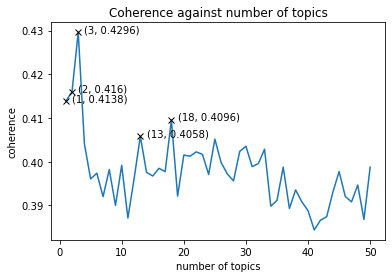

In [23]:
# plot coherence vs num_topics
num_topics = [_['num_topics'] for _ in validation_results]
coherences = np.array([_['coherence'] for _ in validation_results])
plt.plot(num_topics, coherences)

# annotate top three coherence scores
best_indices = np.argsort(coherences)[-5:]
for i in best_indices:
    bestk = num_topics[i]
    score = coherences[i]
    plt.plot(bestk, score, marker='x', color='black')
    plt.text(
        x=bestk+1, y=score, s=f"({bestk}, {score:.4})")

plt.title("Coherence against number of topics")
plt.ylabel("coherence")
plt.xlabel("number of topics")
plt.show()

In [29]:
# manually inspect LDA models with best num_topics
bestk_to_model = {}
for i in best_indices:
    bestk = num_topics[i]
    if bestk == 1: continue
    print(f"training LDA model with num_topics={bestk}")
    lda_model = LdaModel(
        corpus=corpus, 
        id2word=dictionary,
        num_topics=bestk,
        alpha='auto',
        eta='auto',
        random_state=1
    )

    bestk_to_model[bestk] = lda_model

training LDA model with num_topics=13
training LDA model with num_topics=18
training LDA model with num_topics=2
training LDA model with num_topics=3


In [30]:
# display topics detected by each model
bestk_to_topicwords = {}
for bestk, model in bestk_to_model.items():
    print(f"\nnumber of topics: {bestk}")

    full_topicwords = []
    for _, topicwords in model.show_topics(num_topics=bestk, formatted=False):
        topicwords = ', '.join([_[0] for _ in topicwords])
        print(f"- {topicwords}")

        full_topicwords.append(topicwords)

    bestk_to_topicwords[bestk] = full_topicwords


number of topics: 13
- fair_value, temenos, sfs_group, client, executive_board, swiss_post, vifor_pharma, interest_rate, annual_general, tecan
- temenos, swiss_post, fair_value, client, gri, interest_rate, vifor_pharma, tecan, bucher_industries, datwyler
- temenos, fair_value, komax, gri, client, vifor_pharma, bucher_industries, banking, nestl, executive_board
- tecan, coop, temenos, fair_value, und, coop_group, retail, lease, datwyler, pmi
- fair_value, swiss_post, komax, vifor_pharma, executive_board, real_estate, temenos, asset_liability, schindler, client
- fair_value, gf, swiss_post, interest_rate, executive_board, mch_group, vifor_pharma, coop, client, annual_general
- swiss_post, vifor_pharma, fair_value, temenos, executive_board, postfinance, patient, million_franc, client, coop
- vifor_pharma, temenos, fair_value, sfs_group, interest_rate, swiss_post, non_current, executive_board, eur, annual_general
- fair_value, givaudan, client, temenos, gf, swiss_post, komax, tecan, non_c

In [31]:
# create dataframe of topic probabilities for each num_topics and each document
bestk_to_df = {}
for bestk, model in bestk_to_model.items():
    df = []

    for x, bow in zip(data, corpus):
        topics = model.get_document_topics(bow)
        out = {'filepath': x['filepath'], 'group': x['group']}
        for topic_id, score in topics:
            out[f'topic_{topic_id:0>2}'] = score

        df.append(out)

    df = pd.DataFrame(df).fillna(0)
    df = df[sorted(df.columns)]

    print(f"num_topics = {bestk}")
    display(df.head())

    bestk_to_df[bestk] = df

num_topics = 13


,filepath,group,topic_00,topic_01,topic_02,topic_03,topic_04,topic_05,topic_06,topic_07,topic_08,topic_09,topic_10,topic_11,topic_12
0,../data/original/other/rece8wrYCNsFIJhES.txt,other,0.000000,0.0,0.000000,0.000000,0.000000,0.908908,0.000000,0.000000,0.025152,0.000000,0.064559,0.0,0.000000
1,../data/original/other/recWRLQhEWkf6UDE0.txt,other,0.034096,0.0,0.000000,0.012286,0.012364,0.269049,0.069664,0.383703,0.000000,0.166953,0.018409,0.0,0.029260
2,../data/original/other/rectaz8xKB9iBtv3Z.txt,other,0.000000,0.0,0.475345,0.000000,0.018733,0.034380,0.000000,0.000000,0.056883,0.000000,0.000000,0.0,0.396794
3,../data/original/other/rec7eKMt3qYFNqwmT.txt,other,0.000000,0.0,0.000000,0.000000,0.000000,0.999442,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,../data/original/other/recbunO9TSS0mACeN.txt,other,0.017169,0.0,0.000000,0.000000,0.000000,0.807521,0.000000,0.000000,0.000000,0.000000,0.171307,0.0,0.000000


num_topics = 18


,filepath,group,topic_00,topic_01,topic_02,topic_03,topic_04,topic_05,topic_06,topic_07,topic_08,topic_09,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17
0,../data/original/other/rece8wrYCNsFIJhES.txt,other,0.000000,0.0,0.000000,0.000000,0.000000,0.907946,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.081903,0.0,0.0,0.000000
1,../data/original/other/recWRLQhEWkf6UDE0.txt,other,0.021842,0.0,0.000000,0.000000,0.016833,0.253455,0.044926,0.045472,0.0,0.5665,0.026253,0.0,0.017060,0.000000,0.000000,0.0,0.0,0.000000
2,../data/original/other/rectaz8xKB9iBtv3Z.txt,other,0.061801,0.0,0.267452,0.100783,0.250525,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.047568,0.126189,0.000000,0.0,0.0,0.130507
3,../data/original/other/rec7eKMt3qYFNqwmT.txt,other,0.000000,0.0,0.000000,0.000000,0.000000,0.999428,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,../data/original/other/recbunO9TSS0mACeN.txt,other,0.051207,0.0,0.000000,0.000000,0.000000,0.512569,0.000000,0.000000,0.0,0.0000,0.422473,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000


num_topics = 2


,filepath,group,topic_00,topic_01
0,../data/original/other/rece8wrYCNsFIJhES.txt,other,0.041290,0.958710
1,../data/original/other/recWRLQhEWkf6UDE0.txt,other,0.982387,0.017613
2,../data/original/other/rectaz8xKB9iBtv3Z.txt,other,0.944267,0.055733
3,../data/original/other/rec7eKMt3qYFNqwmT.txt,other,0.994240,0.000000
4,../data/original/other/recbunO9TSS0mACeN.txt,other,0.885452,0.114548


num_topics = 3


,filepath,group,topic_00,topic_01,topic_02
0,../data/original/other/rece8wrYCNsFIJhES.txt,other,0.010245,0.355057,0.634698
1,../data/original/other/recWRLQhEWkf6UDE0.txt,other,0.823718,0.028814,0.147468
2,../data/original/other/rectaz8xKB9iBtv3Z.txt,other,0.044400,0.010818,0.944782
3,../data/original/other/rec7eKMt3qYFNqwmT.txt,other,0.879076,0.000000,0.117615
4,../data/original/other/recbunO9TSS0mACeN.txt,other,0.846437,0.066758,0.086806


In [32]:
# sum of scores per topic per group
outpath = path.join(output_dir, f"summed-scores-by-group.txt")
f_out = open(outpath, 'w')

for bestk, df in bestk_to_df.items():
    print(f"num_topics = {bestk}:")
    topic_scores = df.groupby('group').sum().transpose()
    topic_scores['topic_words'] = bestk_to_topicwords[bestk]
    display(topic_scores)

    print(f"num_topics = {bestk}", file=f_out)
    print(topic_scores.to_string(), file=f_out)
    print("\n\n", file=f_out)

f_out.close()

num_topics = 13:


group,other,sustainability,topic_words
topic_00,8.077175,1.654688,"fair_value, temenos, sfs_group, client, executive_board, swiss_post, vifor_pharma, interest_rate, annual_general, tecan"
topic_01,2.759618,11.186677,"temenos, swiss_post, fair_value, client, gri, interest_rate, vifor_pharma, tecan, bucher_industries, datwyler"
topic_02,4.310951,8.463999,"temenos, fair_value, komax, gri, client, vifor_pharma, bucher_industries, banking, nestl, executive_board"
topic_03,5.179934,10.095877,"tecan, coop, temenos, fair_value, und, coop_group, retail, lease, datwyler, pmi"
topic_04,6.135603,1.378133,"fair_value, swiss_post, komax, vifor_pharma, executive_board, real_estate, temenos, asset_liability, schindler, client"
topic_05,15.277400,3.897565,"fair_value, gf, swiss_post, interest_rate, executive_board, mch_group, vifor_pharma, coop, client, annual_general"
topic_06,9.501961,1.215951,"swiss_post, vifor_pharma, fair_value, temenos, executive_board, postfinance, patient, million_franc, client, coop"
topic_07,0.682268,0.553906,"vifor_pharma, temenos, fair_value, sfs_group, interest_rate, swiss_post, non_current, executive_board, eur, annual_general"
topic_08,3.173716,1.836271,"fair_value, givaudan, client, temenos, gf, swiss_post, komax, tecan, non_current, interest_rate"
topic_09,3.730662,11.637835,"child, vifor_pharma, fair_value, coop, nestl, tecan, client, real_estate, givaudan, executive_board"


num_topics = 18:


group,other,sustainability,topic_words
topic_00,8.122088,1.388290,"fair_value, sfs_group, executive_board, client, temenos, swiss_post, interest_rate, annual_general, vifor_pharma, tecan"
topic_01,2.209436,5.554613,"temenos, swiss_post, fair_value, client, gri, tecan, interest_rate, vifor_pharma, bucher_industries, datwyler"
topic_02,4.570840,8.001380,"temenos, fair_value, komax, client, gri, vifor_pharma, banking, nestl, bucher_industries, executive_board"
topic_03,4.159582,8.677244,"tecan, coop, temenos, fair_value, coop_group, und, retail, lease, client, annual_general"
topic_04,4.828914,0.483325,"fair_value, swiss_post, komax, executive_board, vifor_pharma, real_estate, temenos, client, annual_general, usd_million"
topic_05,14.909712,4.037046,"fair_value, gf, swiss_post, mch_group, interest_rate, executive_board, vifor_pharma, postfinance, coop, non_current"
topic_06,8.475392,1.630627,"swiss_post, vifor_pharma, fair_value, temenos, postfinance, patient, executive_board, million_franc, client, coop"
topic_07,0.295645,0.183568,"vifor_pharma, temenos, fair_value, sfs_group, swiss_post, interest_rate, non_current, executive_board, pmi, eur"
topic_08,2.174144,0.322183,"fair_value, client, givaudan, gf, temenos, komax, swiss_post, non_current, interest_rate, tecan"
topic_09,4.504019,7.863563,"child, vifor_pharma, fair_value, nestl, coop, client, real_estate, child_labor, executive_board, patient"


num_topics = 2:


group,other,sustainability,topic_words
topic_00,55.853717,13.892181,"fair_value, executive_board, vifor_pharma, temenos, client, swiss_post, annual_general, interest_rate, eur, sfs_group"
topic_01,23.057211,61.011653,"temenos, swiss_post, fair_value, vifor_pharma, client, gf, gri, child, tecan, interest_rate"


num_topics = 3:


group,other,sustainability,topic_words
topic_00,40.400019,8.605163,"fair_value, swiss_post, executive_board, vifor_pharma, client, sfs_group, temenos, interest_rate, annual_general, tecan"
topic_01,19.411438,30.755332,"swiss_post, temenos, fair_value, vifor_pharma, client, tecan, interest_rate, child, gri, non_current"
topic_02,19.085713,35.517637,"fair_value, temenos, vifor_pharma, gf, komax, client, gri, executive_board, givaudan, non_current"
